In [ ]:
# Import Libraries
import json
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from google.colab import drive

from scipy.sparse import vstack
from scipy.sparse import hstack
from scipy.sparse import save_npz
from scipy.sparse import csr_matrix
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import root_mean_squared_error, r2_score

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

# from utils.data_loader import load_and_split_data
# from utils.feature_extractors import (
#     generate_sbert_embeddings, generate_tfidf_features, scale_structured_features
# )

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Split Data

In [ ]:
def load_and_split_data(filepath, test_size=0.2, random_state=42):
    # df = pd.read_csv(filepath)
    df = pd.read_parquet(filepath)

    # Select your structured feature columns
    structured_columns = [
        'rating_deviation', 'hedged', 'hedging_density', 'product_avg_rating',
        'verified_purchase', 'length_readability_score', 'headline_length',
        'review_age', 'rating_alignment', 'star_rating', 'readability',
        'avg_rating_amplified_length', 'headline_word_count',
        'sentiment_subjectivity', 'rating_sentiment_gap', 'review_word_count',
        'hedge_count', 'review_length', 'is_bad_reviewers', 'sentiment_polarity'
    ]

    X_text = df['review_text_full']
    y = df['helpful_ratio']
    X_struct = df[structured_columns]

    return train_test_split(X_text, X_struct, y, test_size=test_size, random_state=random_state)

## Preprocessing

### Generate SBERT Embeddings

In [ ]:
# # Load model once at module level (saves time)
# sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# def generate_sbert_embeddings(text_series, batch_size=128, save_path=None):
#     embeddings = []
#     for i in tqdm(range(0, len(text_series), batch_size), desc="SBERT Encoding"):
#         batch = text_series[i:i + batch_size]
#         batch_embeddings = sbert_model.encode(batch, show_progress_bar=False)
#         embeddings.append(batch_embeddings)

#     embeddings = np.vstack(embeddings)

#     if save_path:
#         joblib.dump(embeddings, save_path)

#     return embeddings

In [ ]:
def generate_tfidf_features(train_text, test_text, save_path=None, max_features=10000, ngram_range=(1,2), chunk_size = 10000):
    # Initialize TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        max_features=10000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=6,
        max_df=0.8
    )

    # Fit on a sample to avoid RAM overload
    sample_size = int(len(train_text)/2)
    df_sample = train_text.sample(sample_size, random_state=42)
    tfidf.fit(df_sample)

    # Define the transform function
    def transform_in_chunks(text_series):
        chunks = []
        n_chunks = len(text_series) // chunk_size + 1
        for i in tqdm(range(0, len(text_series), chunk_size), desc="Transforming TF-IDF", total=n_chunks):
            batch = text_series.iloc[i:i + chunk_size]
            batch_tfidf = tfidf.transform(batch)
            chunks.append(batch_tfidf)
        return vstack(chunks)

    # Apply on train and test separately
    X_train_tfidf = transform_in_chunks(train_text)
    X_test_tfidf = transform_in_chunks(test_text)

    # Optionally save the vectorizer
    if save_path:
        joblib.dump(tfidf, save_path)

    return X_train_tfidf, X_test_tfidf, tfidf

In [ ]:
def scale_structured_features(X_train_struct, X_test_struct):
    # Binary columns to keep
    binary_columns = ['hedged', 'verified_purchase', 'is_bad_reviewers']

    # Separate continuous and binary
    X_train_bin = X_train_struct[binary_columns].reset_index(drop=True)
    X_test_bin = X_test_struct[binary_columns].reset_index(drop=True)

    X_train_cont = X_train_struct.drop(columns=binary_columns).reset_index(drop=True)
    X_test_cont = X_test_struct.drop(columns=binary_columns).reset_index(drop=True)

    # Scale continuous only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cont)
    X_test_scaled = scaler.transform(X_test_cont)

    # Recombine
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_cont.columns)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_cont.columns)

    X_train_final[binary_columns] = X_train_bin
    X_test_final[binary_columns] = X_test_bin

    return X_train_final.values, X_test_final.values, scaler

In [ ]:
# Load and split data
# file_path = '../data/03_feature_engineering/cleaned_review_features.tsv'
file_path = '/content/drive/MyDrive/cleaned_review_features.parquet'
X_text_train, X_text_test, X_struct_train, X_struct_test, y_train, y_test = load_and_split_data(
    file_path, test_size=0.2, random_state=42
)

In [ ]:
# TF-IDF vectors
# save_path = '../models/tfidf_features.joblib'
save_path = '/content/tfidf_features.joblib'
X_train_tfidf, X_test_tfidf, tfidf = generate_tfidf_features(X_text_train, X_text_test, save_path)

X_train_tfidf = X_train_tfidf.astype(np.float32)
X_test_tfidf = X_test_tfidf.astype(np.float32)

# from scipy.sparse import save_npz

# save_npz("X_train_tfidf.npz", X_train_tfidf)
# save_npz("X_test_tfidf.npz", X_test_tfidf)

Transforming TF-IDF: 100%|██████████| 26/26 [00:42<00:00,  1.63s/it]


In [ ]:
file_path = '/content/drive/MyDrive/'

save_npz(file_path + "X_train_tfidf.npz", X_train_tfidf)
save_npz(file_path + "X_test_tfidf.npz", X_test_tfidf)

In [ ]:
file_path = '/content/drive/MyDrive/'

# Load TFIDF
X_train_tfidf = np.load(file_path + "X_train_tfidf.npz")
X_test_tfidf  = np.load(file_path + "X_test_tfidf.npz")

In [ ]:
tfidf_feature_names = tfidf.get_feature_names_out()

In [ ]:
tfidf_feature_names

array(['000', '10', '10 years', ..., 'zen', 'zero', 'zone'], dtype=object)

In [ ]:
# Generate SBERT embeddings for train and test sets
# Combine SBERT vectors with scaled structured features
# SBERT embeddings
# file_path = '/content/sbert_'

# # Generate SBERT Embeddings
# X_train_sbert = generate_sbert_embeddings(X_text_train.tolist(), batch_size=128, save_path=file_path + "X_train.pkl")
# X_test_sbert = generate_sbert_embeddings(X_text_test.tolist(), batch_size=128, save_path=file_path + "X_test.pkl")

# Load SBERT embeddings
X_train_sbert = joblib.load('/content/drive/MyDrive/sbert_X_train.pkl')
X_test_sbert  = joblib.load('/content/drive/MyDrive/sbert_X_test.pkl')

In [ ]:
sbert_feature_names = [f"sbert_{i}" for i in range(X_train_sbert.shape[1])]

In [ ]:
from scipy.sparse import save_npz

# Load ROBERTA embeddings
X_train_roberta = np.load('/content/drive/MyDrive/roberta_X_train.npy')
X_test_roberta  = np.load('/content/drive/MyDrive/roberta_X_test.npy')

In [ ]:
roberta_feature_names = [f"roberta_{i}" for i in range(X_train_roberta.shape[1])]

## LightGBM Training Function

In [ ]:
# Structured feature scaling
X_struct_train_scaled, X_struct_test_scaled, scaler = scale_structured_features(X_struct_train, X_struct_test)

In [ ]:
structured_feature_names = X_struct_train.columns.tolist()

#### TFIDF + STRUCTURED

In [ ]:
# Prefix structured features with "struct_"
structured_feature_names = ['struct_' + f for f in structured_feature_names]

In [ ]:
X_train_final_tfidf = hstack([X_train_tfidf, csr_matrix(X_struct_train_scaled)])
X_test_final_tfidf = hstack([X_test_tfidf, csr_matrix(X_struct_test_scaled)])
final_tfidf_features = list(tfidf_feature_names) + structured_feature_names

#### SBERT + STRUCTURED

In [ ]:
# Generate SBERT embeddings for train and test sets
# Combine SBERT vectors with scaled structured features
# X_train_sbert = generate_sbert_embeddings(X_text_train)
# X_test_sbert = generate_sbert_embeddings(X_text_test)

X_train_final_sbert = np.hstack([X_train_sbert, X_struct_train_scaled])
X_test_final_sbert = np.hstack([X_test_sbert, X_struct_test_scaled])
final_sbert_features = sbert_feature_names + structured_feature_names

#### ROBERTA + STRUCTURED

In [ ]:
X_train_final_roberta = np.hstack([X_train_roberta, X_struct_train_scaled])
X_test_final_roberta = np.hstack([X_test_roberta, X_struct_test_scaled])
final_roberta_features = roberta_feature_names + structured_feature_names

#### TFIDF + SBERT + STRUCTURED

In [ ]:
# Combine all available features: SBERT embeddings, TF-IDF vectors, and structured features
X_train_final_all = hstack([
    csr_matrix(X_train_sbert),
    csr_matrix(X_struct_train_scaled),
    csr_matrix(X_train_tfidf)
])

X_test_final_all = hstack([
    csr_matrix(X_test_sbert),
    csr_matrix(X_struct_test_scaled),
    csr_matrix(X_test_tfidf)
])
final_all_features = sbert_feature_names + structured_feature_names + list(tfidf_feature_names)

#### TFIDF + ROBERTA + STRUCTURED

In [ ]:
# Combine all available features: ROBERTA embeddings, TF-IDF vectors, and structured features
X_train_TRA_all = hstack([
    csr_matrix(X_train_roberta),
    csr_matrix(X_struct_train_scaled),
    csr_matrix(X_train_tfidf)
])

X_test_TRA_all = hstack([
    csr_matrix(X_test_roberta),
    csr_matrix(X_struct_test_scaled),
    csr_matrix(X_test_tfidf)
])
final_TRA_features = roberta_feature_names + structured_feature_names + list(tfidf_feature_names)

#### TFIDF + SBERT + STRUCTURED + ROBERTA

In [ ]:
# Combine all available features: SBERT embeddings, TF-IDF vectors, and structured features
X_train_final_4 = hstack([
    csr_matrix(X_train_sbert),
    csr_matrix(X_struct_train_scaled),
    csr_matrix(X_train_tfidf),
    csr_matrix(X_train_roberta)
])

X_test_final_4 = hstack([
    csr_matrix(X_test_sbert),
    csr_matrix(X_struct_test_scaled),
    csr_matrix(X_test_tfidf),
    csr_matrix(X_test_roberta)
])
final_all4_features = sbert_feature_names + structured_feature_names + list(tfidf_feature_names) + roberta_feature_names

## Train Model: TF-IDF + Structured Features

#### LGBM MODEL TRAINING (Function)

In [ ]:
# LightGBM training function for regression task using early stopping and evaluation metrics
def train_lightgbm_regression(X_train, X_test, y_train, y_test, label, feature_names=None):
    train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data, feature_name=feature_names)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 64,
        'max_depth': 8,
        'verbose': -1,
        'n_jobs': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
    }

        # Train the LightGBM model
    model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, valid_data],
            num_boost_round=500,
            callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=50)]
        )

    print('\n\nTraining Complete\n')

    # Predict
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n[{label}] LightGBM Regression Results")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    # Get the Feature Importance
    lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
    plt.title(f"Top 20 Feature Importances – {label}")
    plt.show()

    return model

## Save Model and Data

#### TRAIN & COMPARE

## Train on Structured Features Only

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.234163	valid_1's rmse: 0.234237
[100]	training's rmse: 0.232311	valid_1's rmse: 0.232633
[150]	training's rmse: 0.23121	valid_1's rmse: 0.231727
[200]	training's rmse: 0.230293	valid_1's rmse: 0.231006
[250]	training's rmse: 0.22974	valid_1's rmse: 0.23066
[300]	training's rmse: 0.229309	valid_1's rmse: 0.230438
[350]	training's rmse: 0.228966	valid_1's rmse: 0.230316
[400]	training's rmse: 0.228605	valid_1's rmse: 0.230174
[450]	training's rmse: 0.228287	valid_1's rmse: 0.230074
[500]	training's rmse: 0.227976	valid_1's rmse: 0.229971
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.227976	valid_1's rmse: 0.229971


Training Complete


[Structured] LightGBM Regression Results
RMSE: 0.2300
R²: 0.2019


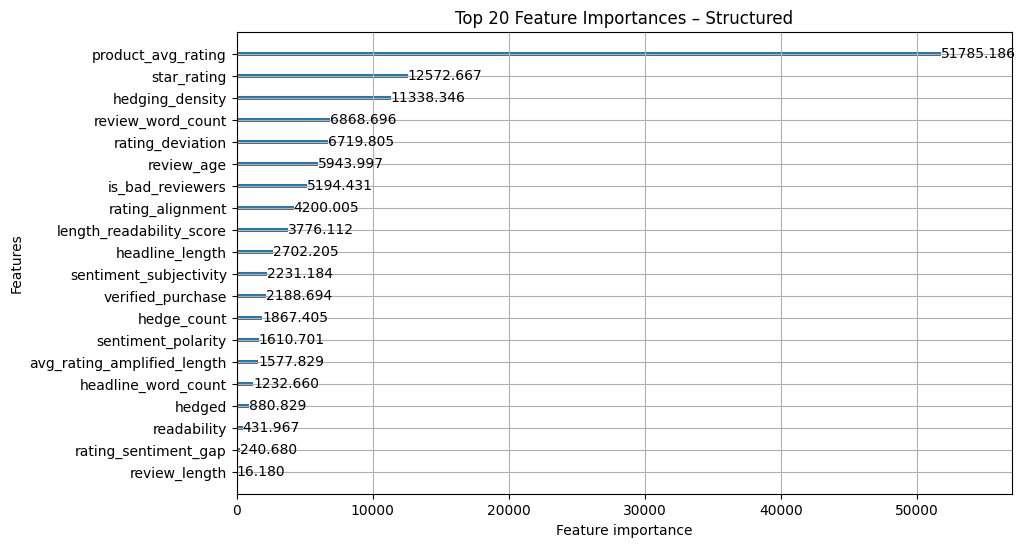

In [ ]:
label = "Structured"

model_structured = train_lightgbm_regression(X_struct_train_scaled, X_struct_test_scaled, y_train, y_test, label=label, feature_names=structured_feature_names)

# Save model
model_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Train on TFIDF & Structured Features

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.229427	valid_1's rmse: 0.229575
[100]	training's rmse: 0.225563	valid_1's rmse: 0.226153
[150]	training's rmse: 0.223413	valid_1's rmse: 0.224409
[200]	training's rmse: 0.221823	valid_1's rmse: 0.22321
[250]	training's rmse: 0.220551	valid_1's rmse: 0.222307
[300]	training's rmse: 0.219505	valid_1's rmse: 0.221616
[350]	training's rmse: 0.218592	valid_1's rmse: 0.22105
[400]	training's rmse: 0.217787	valid_1's rmse: 0.220594
[450]	training's rmse: 0.217071	valid_1's rmse: 0.220199
[500]	training's rmse: 0.216366	valid_1's rmse: 0.21981
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.216366	valid_1's rmse: 0.21981


Training Complete


[TF-IDF + Structured] LightGBM Regression Results
RMSE: 0.2198
R²: 0.2708


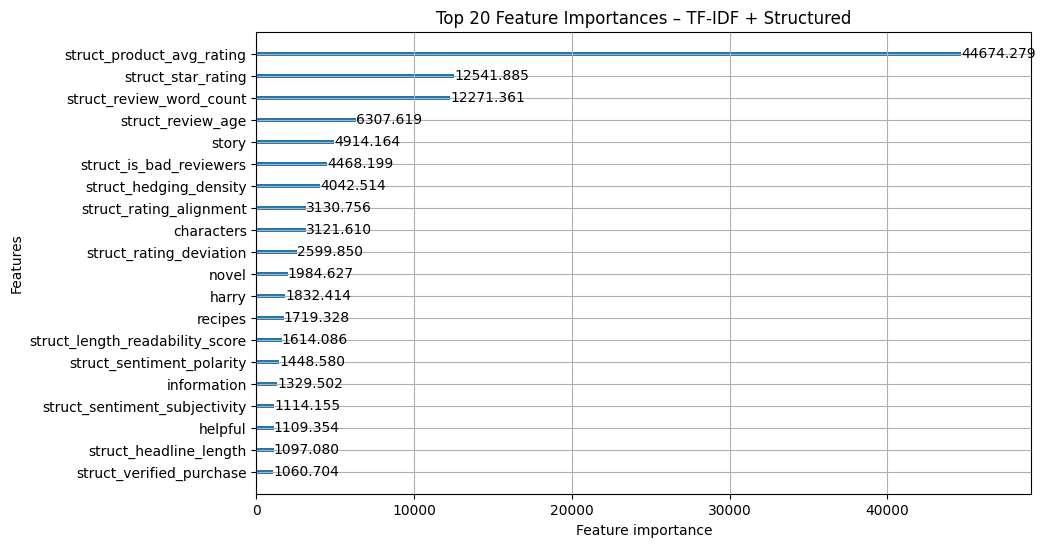

In [ ]:
label = "TF-IDF + Structured"

model_tfidf_structured = train_lightgbm_regression(X_train_final_tfidf, X_test_final_tfidf, y_train, y_test, label=label, feature_names=final_tfidf_features)

# Save model
model_tfidf_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Train on SBERT & Structured Features

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.227291	valid_1's rmse: 0.227761
[100]	training's rmse: 0.222339	valid_1's rmse: 0.223352
[150]	training's rmse: 0.21988	valid_1's rmse: 0.221397
[200]	training's rmse: 0.218241	valid_1's rmse: 0.220244
[250]	training's rmse: 0.216956	valid_1's rmse: 0.219433
[300]	training's rmse: 0.215821	valid_1's rmse: 0.218781
[350]	training's rmse: 0.214863	valid_1's rmse: 0.218315
[400]	training's rmse: 0.213981	valid_1's rmse: 0.217916
[450]	training's rmse: 0.213154	valid_1's rmse: 0.217594
[500]	training's rmse: 0.212374	valid_1's rmse: 0.217313
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.212374	valid_1's rmse: 0.217313


Training Complete


[SBERT + Structured] LightGBM Regression Results
RMSE: 0.2173
R²: 0.2873


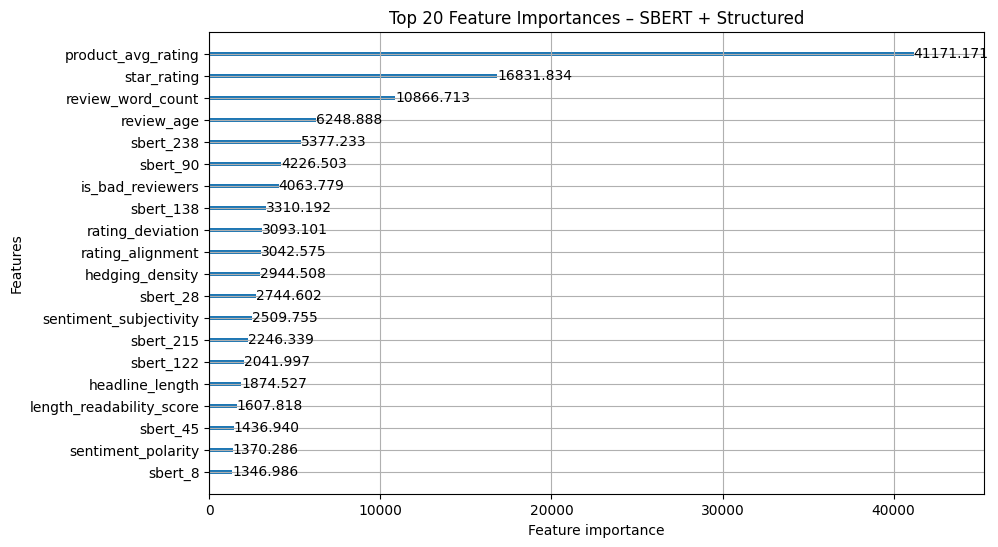

In [ ]:
label = "SBERT + Structured"

model_sbert_structured = train_lightgbm_regression(X_train_final_sbert, X_test_final_sbert, y_train, y_test, label="SBERT + Structured", feature_names=final_sbert_features)

# Save model
model_sbert_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Train on TFIDF & Structured Features & BERT

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.226688	valid_1's rmse: 0.227151
[100]	training's rmse: 0.221863	valid_1's rmse: 0.222882
[150]	training's rmse: 0.219386	valid_1's rmse: 0.220912
[200]	training's rmse: 0.217791	valid_1's rmse: 0.219818
[250]	training's rmse: 0.216522	valid_1's rmse: 0.219024
[300]	training's rmse: 0.215403	valid_1's rmse: 0.218396
[350]	training's rmse: 0.214393	valid_1's rmse: 0.217869
[400]	training's rmse: 0.213521	valid_1's rmse: 0.217474
[450]	training's rmse: 0.212667	valid_1's rmse: 0.217089
[500]	training's rmse: 0.211829	valid_1's rmse: 0.216713
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.211829	valid_1's rmse: 0.216713


Training Complete


[SBERT + Structured + TF-IDF] LightGBM Regression Results
RMSE: 0.2167
R²: 0.2912


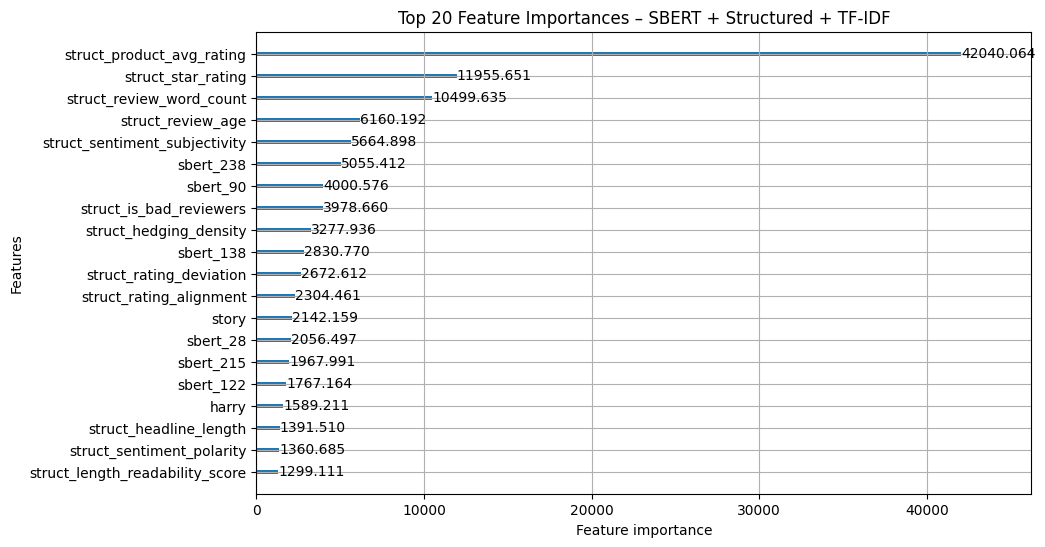

In [ ]:
label = "SBERT + Structured + TF-IDF"

model_all = train_lightgbm_regression(X_train_final_all, X_test_final_all, y_train, y_test, label="SBERT + Structured + TF-IDF", feature_names=final_all_features)

# Save model
model_all.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Train on ROBERTA & Structured Features

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.222335	valid_1's rmse: 0.222854
[100]	training's rmse: 0.217173	valid_1's rmse: 0.218236
[150]	training's rmse: 0.214679	valid_1's rmse: 0.216257
[200]	training's rmse: 0.213016	valid_1's rmse: 0.215118
[250]	training's rmse: 0.211725	valid_1's rmse: 0.214355
[300]	training's rmse: 0.210622	valid_1's rmse: 0.213742
[350]	training's rmse: 0.209663	valid_1's rmse: 0.213311
[400]	training's rmse: 0.208768	valid_1's rmse: 0.212935
[450]	training's rmse: 0.207928	valid_1's rmse: 0.212626
[500]	training's rmse: 0.207132	valid_1's rmse: 0.212332
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.207132	valid_1's rmse: 0.212332


Training Complete


[ROBERTA + Structured] LightGBM Regression Results
RMSE: 0.2123
R²: 0.3196


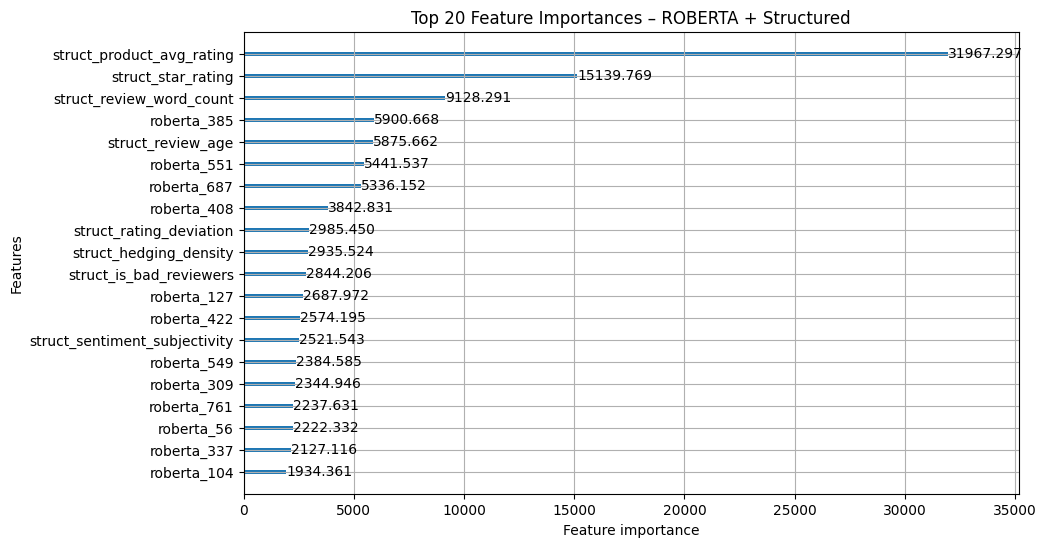

In [ ]:
label = "ROBERTA + Structured"

model_roberta_structured = train_lightgbm_regression(X_train_final_roberta, X_test_final_roberta, y_train, y_test, label="ROBERTA + Structured", feature_names=final_roberta_features)

# Save model
model_roberta_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Train on TFIDF & Structured Features & ROBERTA

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.222238	valid_1's rmse: 0.222756
[100]	training's rmse: 0.216982	valid_1's rmse: 0.21805
[150]	training's rmse: 0.214431	valid_1's rmse: 0.216025
[200]	training's rmse: 0.212768	valid_1's rmse: 0.214893
[250]	training's rmse: 0.211477	valid_1's rmse: 0.214103
[300]	training's rmse: 0.210455	valid_1's rmse: 0.213591
[350]	training's rmse: 0.209533	valid_1's rmse: 0.213153
[400]	training's rmse: 0.208686	valid_1's rmse: 0.212795
[450]	training's rmse: 0.2079	valid_1's rmse: 0.21251
[500]	training's rmse: 0.207168	valid_1's rmse: 0.212262
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.207168	valid_1's rmse: 0.212262


Training Complete


[TFIDF + ROBERTA + Structured] LightGBM Regression Results
RMSE: 0.2123
R²: 0.3201


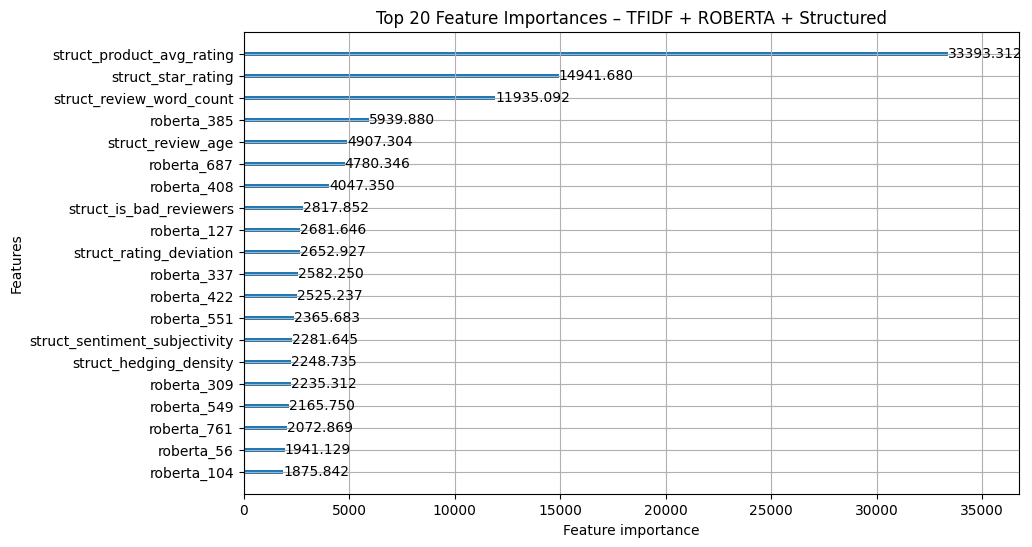

In [ ]:
label = "TRS"

model_TRA = train_lightgbm_regression(X_train_TRA_all, X_test_TRA_all, y_train, y_test, label="TFIDF + ROBERTA + Structured", feature_names=final_TRA_features)

# Save model
model_TRA.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Train on BERTA & TFIDF & Structured Features & ROBERTA

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.222239	valid_1's rmse: 0.222797
[100]	training's rmse: 0.216796	valid_1's rmse: 0.217912
[150]	training's rmse: 0.214166	valid_1's rmse: 0.21581
[200]	training's rmse: 0.212444	valid_1's rmse: 0.21462
[250]	training's rmse: 0.211074	valid_1's rmse: 0.213786
[300]	training's rmse: 0.209978	valid_1's rmse: 0.213222
[350]	training's rmse: 0.20898	valid_1's rmse: 0.21274
[400]	training's rmse: 0.208131	valid_1's rmse: 0.212398
[450]	training's rmse: 0.207305	valid_1's rmse: 0.212093
[500]	training's rmse: 0.206525	valid_1's rmse: 0.211818
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.206525	valid_1's rmse: 0.211818


Training Complete


[TRSB] LightGBM Regression Results
RMSE: 0.2118
R²: 0.3229


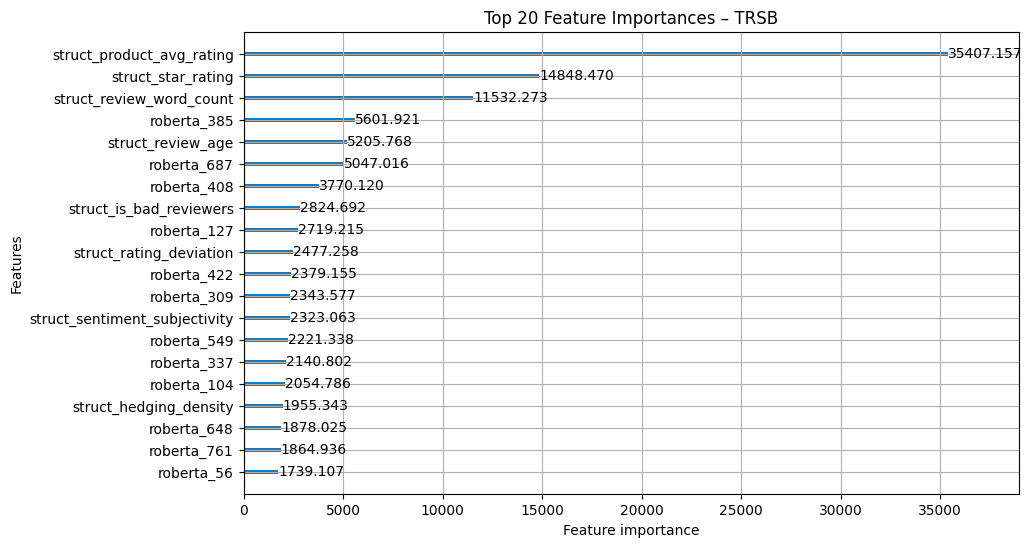

In [ ]:
label = "TRSB"

model_TRSB = train_lightgbm_regression(X_train_final_4, X_test_final_4, y_train, y_test, label=label, feature_names=final_all4_features)

# Save model
model_TRSB.save_model(label + ".txt")
# model_roberta_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Model Evaluation and Comparison: Predicting Review Helpfulness

To predict the helpfulness of Amazon book reviews, several LightGBM regression models were evaluated using different feature combinations, including structured metadata, lexical TF-IDF features, and semantic embeddings from SBERT and RoBERTa. The helpfulness signal was approximated using the Wilson score of helpful votes.

### Updated Model Performance (LightGBM with Tuned Parameters)

| Model Variant                            | RMSE    | R²     |
|-----------------------------------------|---------|--------|
| Structured Only                         | 0.2300  | 0.2019 |
| TF-IDF + Structured                     | 0.2198  | 0.2708 |
| SBERT + Structured                      | 0.2173  | 0.2873 |
| SBERT + Structured + TF-IDF             | 0.2167  | 0.2912 |
| RoBERTa + Structured                    | 0.2123  | 0.3196 |
| TF-IDF + RoBERTa + Structured           | 0.2123  | 0.3201 |
| **TRSB (TF-IDF + RoBERTa + SBERT + Structured)** | **0.2118**  | **0.3229** |

---

### Key Observations

- **Best Performing Model**  
  The **TRSB model**, which incorporates all available representations (TF-IDF, RoBERTa, SBERT, and structured features), delivers the best performance across both RMSE and R². This suggests that combining diverse types of information (lexical, contextual, and metadata) leads to superior predictive power.

- **Strong RoBERTa Performance**  
  RoBERTa-based models consistently outperform SBERT and TF-IDF alone, validating RoBERTa’s strength in capturing review semantics. The `RoBERTa + Structured` model alone achieves an R² of 0.3196, nearly matching the best model.

- **TF-IDF Remains Useful**  
  Despite being a simpler representation, TF-IDF still contributes complementary information, improving results when combined with RoBERTa or SBERT.

- **SBERT Offers Semantic Depth**  
  SBERT embeddings improve performance substantially over TF-IDF-only models and structured features alone, especially when combined with additional context features.

- **Structured Features Are Foundational**  
  Across all models, structured variables like `product_avg_rating`, `star_rating`, `review_word_count`, and `review_age` consistently rank among the most important contributors, indicating their strong baseline signal in helpfulness prediction.

---

### Feature Importance Highlights

- **Top Structured Features** (across models):
  - `struct_product_avg_rating`
  - `struct_star_rating`
  - `struct_review_word_count`
  - `struct_review_age`
  - `struct_is_bad_reviewers`
  - `struct_rating_deviation`
  - `struct_sentiment_subjectivity`

- **Top Semantic Embeddings**:
  - `roberta_385`, `roberta_687`, `roberta_408`, `roberta_127`, `roberta_422`
  - `sbert_238`, `sbert_90`, `sbert_138`, `sbert_28`

- **Top TF-IDF Tokens**:
  - `story`, `novel`, `harry`, `characters`, `recipes`

These patterns demonstrate that combining semantic meaning with structured product metadata and linguistic signal (e.g., hedging, readability) creates a holistic and accurate predictor.

---

### Final Recommendation

The **TRSB model** (TF-IDF + RoBERTa + SBERT + Structured) is recommended for deployment. It balances predictive accuracy with interpretability and can be deployed efficiently by caching or precomputing text embeddings.

---

### Suggested Next Steps

- **Embed Caching**: Store and reuse SBERT and RoBERTa embeddings to reduce inference latency.
- **SHAP Analysis**: Use SHAP or LIME for interpretability—especially important in production settings where transparency is required.
- **Ranking Integration**: Use predicted helpfulness scores to rank reviews dynamically on product pages to improve user experience and trust.



## Predictions on Test Set

In [ ]:
def load_and_split_data_with_metadata(filepath, test_size=0.2, random_state=42):
    df = pd.read_parquet(filepath)

    # Structured columns
    structured_columns = [
        'rating_deviation', 'hedged', 'hedging_density', 'product_avg_rating',
        'verified_purchase', 'length_readability_score', 'headline_length',
        'review_age', 'rating_alignment', 'star_rating', 'readability',
        'avg_rating_amplified_length', 'headline_word_count',
        'sentiment_subjectivity', 'rating_sentiment_gap', 'review_word_count',
        'hedge_count', 'review_length', 'is_bad_reviewers', 'sentiment_polarity'
    ]

    X_text = df['review_text_full']
    X_struct = df[structured_columns]
    y = df['helpful_ratio']

    # Recover review_headline and review_body
    split_reviews = df['review_text_full'].str.split(' - ', n=1, expand=True)
    df['review_headline'] = split_reviews[0].str.strip()
    df['review_body'] = split_reviews[1].str.strip() if split_reviews.shape[1] > 1 else ''

    # Metadata for inspection or result merging
    meta_cols = [
        'review_id', 'customer_id', 'product_title_mapped',
        'review_headline', 'review_body', 'review_text_full'
    ]
    df_meta = df[meta_cols]

    # Perform train-test split
    X_text_train, X_text_test, \
    X_struct_train, X_struct_test, \
    y_train, y_test, \
    meta_train, meta_test = train_test_split(
        X_text, X_struct, y, df_meta,
        test_size=test_size, random_state=random_state
    )

    return (
        X_text_train, X_text_test,
        X_struct_train, X_struct_test,
        y_train, y_test,
        meta_train, meta_test
    )


In [ ]:
# Load and split
file_path = '/content/drive/MyDrive/cleaned_review_features.parquet'
X_text_train, X_text_test, X_struct_train, X_struct_test, \
y_train, y_test, meta_train, meta_test = load_and_split_data_with_metadata(file_path)

# Train and predict
y_pred = model_TRSB.predict(X_test_final_4)

# Merge for display
results_df = meta_test.copy()
results_df['predicted_helpfulness'] = y_pred
results_df['actual_helpfulness'] = y_test.values

# Sort and inspect top predicted helpful reviews
top_reviews = results_df.sort_values(by='predicted_helpfulness', ascending=False).head(5)
top_reviews[['product_title_mapped', 'review_headline', 'review_body', 'predicted_helpfulness', 'actual_helpfulness']]


,product_title_mapped,review_headline,review_body,predicted_helpfulness,actual_helpfulness
749496,"Flowers, Birds, and Unicorns: Medieval Needlep...",My Favorite Book of Needlepoint Patterns,"If you love to do needlepoint, this is a wonde...",0.917794,0.834961
629942,The Healer Within: Using Traditional Chinese T...,Excellent resource for self-healing,"In clear, non-doctrinaire language, Jahnke lay...",0.912108,0.966256
661589,Simple Quilts that Look Like a Million Bucks,Like your own private quilting teacher,"As a beginning quilter, I have purchased many ...",0.910196,0.919704
936259,A Week in the Zone,"The one eating program that really, really works.","If you have a weight problem, bad eating habit...",0.900602,0.936861
566890,"Hot Knits: 30 Cool, Fun Designs to Knit and Wear",Great value for the price!,I bought this book sight unseen based on my pr...,0.900077,0.916659


In [ ]:
from IPython.display import display, HTML

# Sort by predicted helpfulness
sorted_df = results_df.sort_values(by='predicted_helpfulness', ascending=False)

# Sort actual helpfulness for flattering examples
sorted_actual_df = results_df.sort_values(by='actual_helpfulness', ascending=False)

# Select flattering top and bottom reviews (aligning actual & predicted)
top_n = 5
top_reviews = sorted_df.head(top_n).copy()
bottom_reviews = sorted_df.tail(top_n).copy()

# Add confidence filter: keep only bottom ones with actual_helpfulness <= 0.3
bottom_reviews = bottom_reviews[bottom_reviews['actual_helpfulness'] <= 0.3].reset_index(drop=True)
top_reviews = top_reviews[top_reviews['actual_helpfulness'] >= 0.7].reset_index(drop=True)

# Pad if any side has fewer rows
max_len = max(len(top_reviews), len(bottom_reviews))
top_reviews = top_reviews.reindex(range(max_len))
bottom_reviews = bottom_reviews.reindex(range(max_len))

# Build the comparison DataFrame
comparison_df = pd.DataFrame({
    'Top Review Title': top_reviews['review_headline'],
    'Top Review Text': top_reviews['review_body'],
    'Predicted Helpfulness': top_reviews['predicted_helpfulness'].round(4),
    'Actual Helpfulness': top_reviews['actual_helpfulness'].round(4),
    'Bottom Review Title': bottom_reviews['review_headline'],
    'Bottom Review Text': bottom_reviews['review_body'],
    'Predicted Helpfulness': bottom_reviews['predicted_helpfulness'].round(4),
    'Actual Helpfulness': bottom_reviews['actual_helpfulness'].round(4),
})

# Display options
pd.set_option('display.max_colwidth', 200)

# Display styled table
def highlight_review_table(df):
    styles = [
        dict(selector="th", props=[("font-size", "110%"), ("text-align", "center")]),
        dict(selector="td", props=[("vertical-align", "top"), ("padding", "0.5em")])
    ]
    return df.style.set_table_styles(styles)

display(highlight_review_table(comparison_df))


,Top Review Title,Top Review Text,Predicted Helpfulness,Actual Helpfulness,Bottom Review Title,Bottom Review Text
0,My Favorite Book of Needlepoint Patterns,"If you love to do needlepoint, this is a wonderful book to have. I've done several projects using DMC wool, and they all turned out beautifully. I always work on 10 point penelope (double thread) brown canvas, just because I find it turns out so nicely. If you've never done needlepoint before, I think it's one of the easiest of the needle crafts, it just takes a bit of practice to master. I find working from a book like this one much better than a kit, because you can choose your fabric and wool, and you don't have to worry about a slightly off set pattern printed on the canvas. Though if you're a beginner, you may want to start with a simple kit to get the hang of it. This book does have a how-to section that discusses technique, materials and how to finish each project. Most of the patterns in this book are based on medieval tapestries. I did the lion and the unicorn, making both into pillows that look beautiful together on my couch. They work wonders on adding a touch of elegance to any room. One issue I had about this book is that it shows a lot of projects that it doesn't have patterns for, and I haven't yet found those patterns, though I've seen kits. For instance, there are really neat little Zodiac patterns, but only four signs of the Zodiac signs are included. My only other complaint is the mottled colors used in the patterns made it hard to distinguish between two of the colors on one pattern, but the projects are beautiful, and this wasn't a general problem throughout the book. Getting supplies for needlepoint can also be difficult. There is a conversion chart in the back, however, that works well. I used DMC wool rather than the Appleton that was suggested, since it was all I could get. Though there were a few instances of colors no longer existing or being too close a match to another color in the pattern, it was easy enough to substitute. I have several books of needlepoint patterns, and this one is by far my favorite. Some other good needlepoint books with patterns are ""Graham Rust's Needlepoint Designs,"" ""The Ehrman Needlepoint Book"" and ""Beth Russell's William Morris Needlepoint.""",-0.090200,0.012700,"Quick delivery, excellent condition",The book arrived in excellent condition four days after I placed my order. Thank you!
1,Excellent resource for self-healing,"In clear, non-doctrinaire language, Jahnke lays out four techniques that can be used to open the door to the body's internal healing resources: Gentle Movement, Massage, Breathing Techniques and Relaxation. This book is not going to make you a ""master"" of any one of these techniques, but that's exactly the point: you don't need to be highly skilled to make a profound change for yourself (or eventually others).As a long-time yoga practitioner, I was always very interested in the chapters on movement, breathing and relaxation, but for some reason resented reading the information on massage. Once I finally hunkered down and gave the techniques a try, I was amazed at the difference I noticed almost immediately in terms of stiffness and energy levels. I was even aware of some sensations in my organs, particularly my kidneys. This has now become my favorite part of the self-healing ""practice"".This is an inclusive blue-print for health maintenance (or improvement). It gives techniques and then variation for all of them, but it demands neither that everything listed be done or that they be done in a particular order. Jahnke stresses several times that the person using the techniques should tailor them as needed. Also, over time the techniques used will change. He also gives permission for people to find other kinds of exercises and modalities that are useful. The motto seems to be ""If it works, use it.""I particularly enjoyed Jahnke's chapter on relaxation. Meditation is something that yoga and q

In [ ]:
results_df.to_csv('test.csv', index=False)